# Data Science and NLP for Customer Review Analysis
This project involves performing analysis of real hotel review data crawled from the
Tripadvisor website to automatically identify positive and negative keywords and phrases associated
with hotels and to better understand characteristics of data analysis tools, extracting explanatory
review summaries, and human reviewing behavior.

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
from tqdm import tqdm
from collections import Counter
import operator
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
import sklearn
import sklearn.metrics as metrics
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
from IPython.display import display
from PIL import Image

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data=pd.read_csv('reviews.csv',names= ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode'])

In [ ]:
data_df=pd.DataFrame(data)

In [ ]:
data_df.groupby('hotelName')['ratingScore'].count()

hotelName
Baymont by Wyndham Red Deer                         305
Black Knight Inn                                     80
Cambridge Red Deer Hotel &amp; Conference Centre    380
Hampton Inn &amp; Suites by Hilton Red Deer         435
Holiday Inn &amp; Suites Red Deer South             227
Holiday Inn Express Red Deer                        234
Holiday Inn Express Red Deer North                   41
Howard Johnson by Wyndham Red Deer                  160
Mountain View Inn &amp; Suites                       80
Quality Inn &amp; Conference Centre                  50
Radisson Red Deer                                   597
Ramada by Wyndham Red Deer Hotel and Suites         168
Red Deer College Residence                            1
Red Deer Inn &amp; Suites                            11
Rolyn Hills B&amp;B and Guest Ranch                   3
Sandman Hotel Red Deer                               59
Springbett Bed &amp; Breakfast                       13
Staybridge Suites Red Deer North      

**Location: Red Deer, AB**

**Data Cleaning:**
1.   The csv file contains data from other city which needs to be removed from dataframe
2.   Some hotel names have a meaningless substring 'amp;' which needs to be removed
3.   Some hotels only received several reviews so I removed those hotels with received reviews below 10
4.   Some reviews contain special characters which will affect the following analysis so I use re.sub to clean the reviews

**Data Preprocessing:**
1.   Lower case transformer, lemmatizer






In [ ]:
#Clean records from other city
data_df=data_df.loc[data_df['City']=='Red Deer']
#Clean hotels with number of reviews below 10
data_df=data_df[data_df['hotelName'].map(data_df['hotelName'].value_counts())>=10]
data_df.index = np.arange(0, len(data_df) )
#Clean hotel name
clean_name=[str(x).replace('&amp;','&') for x in data_df['hotelName']]
data_df['hotelName']=clean_name
#Clean review string
clean_string=[x.replace('\\n',' ') for x in data_df['reviewColumn']]
clean_string=[re.sub('[^A-Za-z0-9]+',' ',x) for x in clean_string]
clean_string=[re.sub('(u.*[0-9]+[a-zA-Z])',' ',x) for x in clean_string]
data_df['reviewColumn']=clean_string

In [ ]:
tokenizer=RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

In [ ]:
#Review string preprocessing
word_list=[tokenizer.tokenize(x) for x in data_df['reviewColumn']]
for i in range(0,len(word_list)):
    word_list[i]=[word.lower() for word in word_list[i]]
for i in range(0,len(word_list)):
    word_list[i]=[lemmatizer.lemmatize(word) for word in word_list[i]]
for i in range(0,len(word_list)):
    word_list[i] = ' '.join([str(word) for word in word_list[i]]) 
word_list=[x.replace('wa ',' was ') for x in word_list]
word_list=[x.replace('ha ',' has ') for x in word_list]

In [ ]:
data_df['reviewColumn']=word_list

In [ ]:
data_df['ratingScore'].describe()

count    3143.000000
mean        3.958638
std         1.285059
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: ratingScore, dtype: float64

# Part 1: Sentiment analysis and aggregation

Compute average Vader sentiment and average ground truth rating per hotel.

In [ ]:
#Defien a function that can use vader to evaluate sentiment
def evalSentences(sentences, to_df=False, columns=[]):
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [ ]:
reviews = data_df['reviewColumn'].values
review_df = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
review_df['hotelName']=data_df['hotelName']

100%|██████████| 3143/3143 [00:02<00:00, 1201.63it/s]


In [ ]:
#Calculate average rating and average vader per hotel
avgrating=data_df.groupby('hotelName')['ratingScore'].mean()
avgvader=review_df.groupby('hotelName')['vader'].mean()

In [ ]:
#Rank hotel by ground truth sentiment
rank_gt=avgrating.sort_values(ascending=False)
#Show top 5 and bottom 5 hotels
print('Top 5 hotels with average ground truth: \n {}'.format(list((rank_gt[:5].index))))
print('Bottom 5 hotels with average ground truth: \n {}'.format(list((rank_gt[-5:].index))))

Top 5 hotels with average ground truth: 
 ['Springbett Bed & Breakfast', 'Holiday Inn Express Red Deer North', 'Holiday Inn & Suites Red Deer South', 'Hampton Inn & Suites by Hilton Red Deer', 'Holiday Inn Express Red Deer']
Bottom 5 hotels with average ground truth: 
 ['Howard Johnson by Wyndham Red Deer', 'Western Budget Reddeer #1', 'Super 8 by Wyndham Red Deer', 'Red Deer Inn & Suites', 'Travelodge Red Deer']


In [ ]:
#Rank hotel by vader score
rank_vader=avgvader.sort_values(ascending=False)
#Show top 5 and bottom 5 hotels
print('Top 5 hotels with average ground truth: \n {}'.format(list((rank_vader[:5].index))))
print('Bottom 5 hotels with average ground truth: \n {}'.format(list((rank_vader[-5:].index))))

Top 5 hotels with average ground truth: 
 ['Holiday Inn & Suites Red Deer South', 'Hampton Inn & Suites by Hilton Red Deer', 'Holiday Inn Express Red Deer', 'Springbett Bed & Breakfast', 'Holiday Inn Express Red Deer North']
Bottom 5 hotels with average ground truth: 
 ['Howard Johnson by Wyndham Red Deer', 'Western Budget Reddeer #1', 'Red Deer Inn & Suites', 'Super 8 by Wyndham Red Deer', 'Travelodge Red Deer']


**The top 5 hotel and bottom 5 hotel are the same for average vader score and average star rating, but the rank of each hotel is different. The reason might be that some hotels only received a small number of ratings, therefore the average rating can be affected by some extreme ratings (1 or 5) more than those hotels received hundreds of ratings. But vader score only cares about the sentiment of reviews, and if most of the reviews are positive then this hotel will receive higher rating in vader score. Also, vader score contains negative values for negative sentiment reviews, this will also affect the avearge vader score.**

# Part 2: Frequency analysis

Use term frequency of the words for (i) positive reviews and (ii) negative with ground truth
sentiment to rank the top-50 most frequent non-stopwords in the review collection.

In [ ]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('place')
    stop.add('accommodation')
    stop.add('accommodations')
    stop.add('red')
    stop.add('deer')
    stop.add('inn')
    stop.add('holiday')

    return stop

In [ ]:
def getTopK(df, kwords, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = get_stop_words()
    counter = Counter()
    if label_value:
        reviews = df.loc[operation(df[label_column],label_value)][value_column]
    else:
        reviews=df['reviewCol'].values
    for review in reviews:
        word_list=tokenizer.tokenize(review)
        counter.update([word.lower() 
                          for word 
                          in re.findall(r'\w+', review) 
                          if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [ ]:
topk_df=review_df[['reviewCol','vader']]
topk_df['groundTruth']=data_df['groundTruth']

In [ ]:
top50Pos = getTopK(topk_df, 50, label_value='positive')
top50Neg = getTopK(topk_df, 50, label_value='negative')

In [ ]:
top50Pos

[('great', 1289),
 ('clean', 1118),
 ('breakfast', 1048),
 ('good', 915),
 ('friendly', 776),
 ('nice', 744),
 ('would', 723),
 ('stayed', 601),
 ('service', 589),
 ('comfortable', 583),
 ('bed', 571),
 ('pool', 555),
 ('well', 527),
 ('night', 501),
 ('time', 492),
 ('one', 473),
 ('restaurant', 460),
 ('food', 441),
 ('helpful', 402),
 ('recommend', 392),
 ('desk', 374),
 ('hot', 364),
 ('front', 364),
 ('always', 355),
 ('area', 353),
 ('excellent', 347),
 ('also', 325),
 ('location', 323),
 ('day', 277),
 ('definitely', 276),
 ('check', 270),
 ('family', 264),
 ('really', 264),
 ('quiet', 264),
 ('get', 261),
 ('back', 260),
 ('like', 254),
 ('need', 238),
 ('best', 237),
 ('free', 234),
 ('everything', 229),
 ('lot', 228),
 ('staying', 222),
 ('make', 208),
 ('experience', 208),
 ('tub', 206),
 ('easy', 205),
 ('could', 203),
 ('even', 196),
 ('business', 192)]

In [ ]:
top50Neg

[('would', 356),
 ('night', 309),
 ('one', 277),
 ('good', 276),
 ('breakfast', 273),
 ('bed', 272),
 ('clean', 236),
 ('front', 235),
 ('desk', 232),
 ('stayed', 221),
 ('pool', 209),
 ('time', 206),
 ('get', 196),
 ('could', 173),
 ('like', 170),
 ('nice', 161),
 ('never', 161),
 ('bathroom', 157),
 ('need', 157),
 ('door', 156),
 ('day', 153),
 ('back', 149),
 ('old', 145),
 ('even', 140),
 ('told', 139),
 ('service', 130),
 ('work', 128),
 ('check', 126),
 ('great', 125),
 ('friendly', 124),
 ('people', 122),
 ('well', 119),
 ('next', 117),
 ('also', 117),
 ('went', 116),
 ('dirty', 114),
 ('hot', 114),
 ('got', 112),
 ('booked', 106),
 ('food', 106),
 ('lot', 105),
 ('thing', 105),
 ('small', 104),
 ('floor', 104),
 ('area', 102),
 ('morning', 102),
 ('two', 98),
 ('said', 96),
 ('first', 95),
 ('shower', 94)]

**Words like 'pool', 'front', 'desk' are location specific, words like 'breakfast', 'front', 'desk', 'pool' appear in both positive and negative reviews, words like 'clean', 'friendly' appear in both lists is suprising.**

Repeat this analysis for the top-50 noun phrases

In [ ]:
def get_terms(tree):
    for leaf in leaves(tree):
        term = [w for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [ ]:
def leaves(tree):
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()


In [ ]:
stopword_list = get_stop_words()

In [ ]:
def acceptable_word(word, stopword_list=stopword_list):
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

In [ ]:
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [ ]:
def getTopKNP(df, kNPs, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):

    counter = Counter()
    tagger = PerceptronTagger()
    tokenizer=RegexpTokenizer(r'\w+')
    pos_tag = tagger.tag
    if label_value:
        reviews = df.loc[operation(df[label_column],label_value)][value_column]
    else:
        reviews=df['reviewCol'].values
    for review in reviews:
        word_list=tokenizer.tokenize(review)
        taggedToks = pos_tag(word_list)
        grammar = r"""
        NBAR:
            {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
            
        NP:
            {<NBAR>}
            {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
        """
        chunker = nltk.RegexpParser(grammar)
        tree = chunker.parse(taggedToks)
        npTokenList = [word for word in get_terms(tree)]
        finalNPList = flatten_phrase_lists(npTokenList)

        counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(word_list))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk

In [ ]:
top50PosPhrase = getTopKNP(topk_df, 50, label_value='positive')
top50NegPhrase = getTopKNP(topk_df, 50, label_value='negative')

In [ ]:
top50PosPhrase

[('front desk', 184),
 ('hot tub', 117),
 ('complimentary breakfast', 50),
 ('pool area', 46),
 ('continental breakfast', 38),
 ('easy access', 37),
 ('free breakfast', 35),
 ('great service', 32),
 ('comfortable bed', 32),
 ('hot breakfast', 31),
 ('gasoline alley', 27),
 ('great experience', 26),
 ('good value', 26),
 ('great location', 25),
 ('good experience', 23),
 ('first time', 21),
 ('large group', 21),
 ('next time', 20),
 ('great value', 19),
 ('second time', 19),
 ('customer service', 18),
 ('nice touch', 18),
 ('top notch', 18),
 ('great time', 18),
 ('water slide', 17),
 ('good location', 17),
 ('black knight', 17),
 ('good food', 17),
 ('next visit', 16),
 ('next day', 16),
 ('parking lot', 16),
 ('business trip', 16),
 ('excellent service', 16),
 ('reasonable price', 15),
 ('next morning', 15),
 ('main floor', 15),
 ('many time', 15),
 ('good selection', 15),
 ('great job', 15),
 ('last time', 14),
 ('jacuzzi suite', 14),
 ('long day', 14),
 ('breakfast buffet', 14),
 ('

In [ ]:
top50NegPhrase

[('front desk', 130),
 ('parking lot', 37),
 ('hot tub', 31),
 ('pool area', 22),
 ('next morning', 20),
 ('free breakfast', 19),
 ('next day', 19),
 ('hot water', 17),
 ('continental breakfast', 16),
 ('first night', 13),
 ('air conditioner', 12),
 ('credit card', 12),
 ('next time', 11),
 ('non smoking', 11),
 ('customer service', 10),
 ('many time', 10),
 ('front desk clerk', 9),
 ('complimentary breakfast', 9),
 ('second night', 9),
 ('desk clerk', 9),
 ('bathroom door', 8),
 ('next door', 7),
 ('gasoline alley', 7),
 ('first time', 7),
 ('hockey team', 7),
 ('bed sheet', 6),
 ('breakfast area', 6),
 ('mini fridge', 6),
 ('bath tub', 6),
 ('good size', 6),
 ('dire need', 6),
 ('ground floor', 6),
 ('plus side', 6),
 ('long time', 6),
 ('many year', 6),
 ('good thing', 6),
 ('extra blanket', 6),
 ('blow dryer', 6),
 ('travel lodge', 6),
 ('last night', 5),
 ('cell phone', 5),
 ('cold air', 5),
 ('main reason', 5),
 ('western budget', 5),
 ('good experience', 5),
 ('king size bed', 5

**The phrase 'front desk', 'hot tub', 'pool area' etc. appear in both positive and negative reviews. I think all the phrases appear in positive reviews is normal there is no suprising phrases in positive reviews.**

Repeat this analysis again for the top-50 noun phrases using different grammer pattern.

In [ ]:
def new_getTopKNP(df, kNPs, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):

    counter = Counter()
    tagger = PerceptronTagger()
    tokenizer=RegexpTokenizer(r'\w+')
    pos_tag = tagger.tag
    if label_value:
        reviews = df.loc[operation(df[label_column],label_value)][value_column]
    else:
        reviews = df['reviewCol'].values
    for review in reviews:
        word_list=tokenizer.tokenize(review)
        taggedToks = pos_tag(word_list)
        grammar = r"""
        NBAR:
            {<NN.*><VB.*>*<JJ.*>} #Noun+Verb+Adjective
            
        NP:
            {<NBAR>} 
        """
        chunker = nltk.RegexpParser(grammar)
        tree = chunker.parse(taggedToks)
        npTokenList = [word for word in get_terms(tree)]
        finalNPList = flatten_phrase_lists(npTokenList)

        counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(word_list))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk

In [ ]:
new_top50PosPhrase = new_getTopKNP(topk_df, 50, label_value='positive')
new_top50NegPhrase = new_getTopKNP(topk_df, 50, label_value='negative')

In [ ]:
new_top50PosPhrase

[('bed comfortable', 55),
 ('breakfast great', 47),
 ('breakfast good', 37),
 ('service excellent', 27),
 ('service great', 25),
 ('location great', 23),
 ('food good', 21),
 ('pool great', 19),
 ('food great', 18),
 ('year old', 17),
 ('brand new', 15),
 ('pool hot', 13),
 ('bed super', 13),
 ('restaurant good', 13),
 ('breakfast excellent', 12),
 ('breakfast delicious', 11),
 ('bed great', 11),
 ('restaurant great', 11),
 ('location easy', 10),
 ('service friendly', 10),
 ('service good', 10),
 ('food excellent', 10),
 ('food delicious', 9),
 ('pool nice', 9),
 ('breakfast nice', 8),
 ('breakfast awesome', 8),
 ('service quick', 8),
 ('location perfect', 8),
 ('bed comfy', 8),
 ('pool perfect', 7),
 ('front desk', 7),
 ('facility great', 7),
 ('location good', 7),
 ('price right', 7),
 ('lounge great', 7),
 ('breakfast wonderful', 6),
 ('bathroom clean', 6),
 ('breakfast ok', 6),
 ('tub great', 6),
 ('location convenient', 6),
 ('breakfast hot', 6),
 ('pool good', 6),
 ('breakfast am

In [ ]:
new_top50NegPhrase

[('bed comfortable', 27),
 ('year old', 19),
 ('door open', 7),
 ('breakfast good', 6),
 ('service good', 6),
 ('location good', 5),
 ('bed comfy', 5),
 ('price good', 5),
 ('bathroom small', 5),
 ('bed good', 5),
 ('service great', 4),
 ('breakfast great', 4),
 ('pool small', 4),
 ('food good', 4),
 ('price right', 4),
 ('need major', 4),
 ('bit tight', 3),
 ('breakfast fine', 3),
 ('floor dirty', 3),
 ('bed awful', 3),
 ('door wide', 3),
 ('service terrible', 3),
 ('foot black', 3),
 ('bathroom clean', 3),
 ('food average', 3),
 ('pool nice', 3),
 ('pool good', 3),
 ('breakfast available', 3),
 ('nothing special', 3),
 ('front desk', 3),
 ('tv old', 3),
 ('tub nice', 3),
 ('tv good', 3),
 ('bed clean', 3),
 ('wall thin', 3),
 ('paper thin', 2),
 ('breakfast pathetic', 2),
 ('smell awful', 2),
 ('location convenient', 2),
 ('breakfast ok', 2),
 ('way good', 2),
 ('motel fine', 2),
 ('motel clean', 2),
 ('time due', 2),
 ('disgusting dirty', 2),
 ('lot empty', 2),
 ('everything clean',

**I used a noun+verb+adjective pattern, the 
result is quite different from noun phrase I got from the previous part. In the result I got from this part, most adjective after the noun is used to describe the noun in a sentimental way. But some phrases have the same meaning like 'good food' and 'food good'. In the previous part, a lot of phrases are actually nouns without sentiment but the sentiment is pretty clear in result of this part and I think it is better for sentiment analyasis.**

# Part 3: Mutual information

Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentimentbearing non-stopwords in the review collection.

In [ ]:
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    

    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        

    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf


In [ ]:
def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    tagger = PerceptronTagger()
    pos_tag = tagger.tag
    grammar = r"""
        NBAR:
            {<NN.*><VB.*>*<JJ.*>}  #Noun+Verb+Adjective
            
        NP:
            {<NBAR>}
        """
    chunker = nltk.RegexpParser(grammar)
    
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [ ]:
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word/Phrase','MI Score']
    return miScoredf

In [ ]:
top100_word=getTopK(review_df,kwords=100,label_value=None)
pure_review_df=review_df.drop(['hotelName'],axis=1)
final_df_word = dataFrameTransformation(data_df, pure_review_df, top100_word)

In [ ]:
MI_word_df = getMI(top100_word, final_df_word)

In [ ]:
MI_word_df.head(50)

,Word/Phrase,MI Score
0,great,0.036739
87,old,0.024457
56,never,0.019953
6,friendly,0.018540
34,excellent,0.018429
1,clean,0.016121
58,door,0.014402
23,helpful,0.013546
82,amazing,0.013304
14,comfortable,0.012730


**The word great get highest MI score which makes sense because great represents a positive sentiment and if the word great appears in the review it means the customer is not likely to give a bad review.**

In [ ]:
top100_phrase=new_getTopKNP(review_df,kNPs=100,label_value=None)
final_df_phrase = NPdataFrameTransformation(data_df, pure_review_df, top100_phrase)

In [ ]:
MI_phrase_df = getMI(top100_phrase, final_df_phrase)

In [ ]:
MI_phrase_df.head(50)

,Word/Phrase,MI Score
1,breakfast great,0.001878
36,door open,0.001683
7,location great,0.001414
3,year old,0.001414
5,service excellent,0.001240
8,pool great,0.001069
25,service friendly,0.001008
24,location easy,0.001008
27,food excellent,0.001008
43,price good,0.000948


**The phrase got highest MI score is 'breakfast great'. And some pharses like 'service terrible', 'bathroom small' indicates that hotels need to improve in service and room.**

# Part 4: Pointwise mutual informaiton

For ground truth sentiment, calculate the top-50 words according to Pointwise Mutual Information (PMI) of the word occurring with (i) positive reviews and (ii) negative reviews.

In [ ]:
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):
    
    N = df.shape[0]
    
    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [ ]:
PMI_Pos_df_word = pmiForAllCal(final_df_word,top100_word,'positive')

100%|██████████| 100/100 [00:00<00:00, 304.85it/s]


In [ ]:
PMI_Pos_df_word.sort_values('pmi',ascending=0).head(50)

,pmi
amazing,0.293067
easy,0.264896
excellent,0.262801
enjoyed,0.256648
accommodating,0.248886
always,0.230728
lounge,0.222076
wonderful,0.216729
definitely,0.213079
helpful,0.208506


In [ ]:
PMI_Neg_df_word = pmiForAllCal(final_df_word,top100_word,'negative')

100%|██████████| 100/100 [00:00<00:00, 355.30it/s]


In [ ]:
PMI_Neg_df_word.sort_values('pmi',ascending=0).head(50)

,pmi
old,0.986116
never,0.826126
door,0.787208
bathroom,0.631617
got,0.623128
people,0.560374
small,0.546685
booked,0.53383
floor,0.50559
shower,0.487036


**It's pretty interesting that the word 'old' gets the highest PMI score in negative rating and it's also much higher than other words' PMI score, this might indicate customers don't like hotels that looks old. Also the word 'never' got second highest MI score in negative reviews, it is a pretty clear sign of negative review. I noticed MI score of words in negative reviews is much higher than in positve reveiws and the reason might be that postive reviews is about 2 times of negative reviews so px of postive review will be much greater than px of negative review.**

In [ ]:
PMI_Pos_df_phrase = pmiForAllCal(final_df_phrase,top100_phrase,'positive')

100%|██████████| 100/100 [00:00<00:00, 381.44it/s]


In [ ]:
PMI_Pos_df_phrase.sort_values('pmi',ascending=0).head(50)

,pmi
restaurant nice,0.316189
facility nice,0.316189
breakfast better,0.316189
everyone friendly,0.316189
service awesome,0.316189
gluten free,0.316189
service quick,0.316189
location perfect,0.316189
pool perfect,0.316189
breakfast clean,0.316189


In [ ]:
PMI_Neg_df_phrase = pmiForAllCal(final_df_phrase,top100_phrase,'negative')

100%|██████████| 100/100 [00:00<00:00, 361.04it/s]


In [ ]:
PMI_Neg_df_phrase.sort_values('pmi',ascending=0).head(50)

,pmi
door open,1.1512
service terrible,1.01766
tv good,1.01766
price good,0.968874
bathroom small,0.835343
breakfast fine,0.794521
bed clean,0.794521
year old,0.642052
nothing special,0.612199
breakfast okay,0.612199


**The first interesting result is a lot of phrases got same PMI score in positive reveiws, then I found out that the reason is the value of py and pxy are always equal for those phrases, therefore the result is purely N/px, which is a constant number, and this also shows that these phrases never appears in negative reveiws. And it's pretty interesting that 'nothing bad' appears in positive reveiws and 'nothing special' appears in negative reviews, this also indicates that single word is not enough to get the sentiment of the review. And there are also some positive phrases like 'tv good', 'price good' has high PMI score in negative reveiws, this indicates that it is not easy to classify a review purely based on it's sentiment score.**

Repeat this analysis for the single top and single bottom hotel (according to the ground
truth rating).

In [ ]:
avgrating_gt=data_df.groupby('hotelName')['ratingScore'].mean()

In [ ]:
top_hotel=avgrating_gt.sort_values(ascending=False).index[1]
bottom_hotel=avgrating_gt.sort_values(ascending=False).index[-1]

In [ ]:
Q4c_review_df_top=review_df.loc[review_df['hotelName'] == top_hotel]
Q4c_review_df_bottom=review_df.loc[review_df['hotelName']==bottom_hotel]

In [ ]:
#TOP 50 words from top_hotel
top50_words_Q4c_top=getTopK(Q4c_review_df_top,kwords=50,label_value=None)
#TOP 50 words from bottom_hotel
top50_words_Q4c_bottom=getTopK(Q4c_review_df_bottom,kwords=50,label_value=None)
#Top 50 phrases from top_hotel
top50_phrase_Q4c_top=new_getTopKNP(Q4c_review_df_top,kNPs=50,label_value=None)
#TOP 50 phrases from bottom_hotel
top50_phrase_Q4c_bottom=new_getTopKNP(Q4c_review_df_bottom,kNPs=50,label_value=None)


In [ ]:
#Words, top_hotel, positive reviews
final_df_words_Q4c = dataFrameTransformation(data_df, pure_review_df, top50_words_Q4c_top)
PMI_Pos_df_words_Q4c = pmiForAllCal(final_df_words_Q4c,top50_words_Q4c_top,'positive')

100%|██████████| 50/50 [00:00<00:00, 338.32it/s]


In [ ]:
PMI_Pos_df_words_Q4c.sort_values('pmi',ascending=0).head(50)

,pmi
amazing,0.293067
modern,0.272704
easy,0.264896
excellent,0.262801
loved,0.262605
spacious,0.238228
definitely,0.213079
helpful,0.208506
great,0.207107
recommend,0.200153


In [ ]:
#Words, bottom_hotel, negative reviews
final_df_words_Q4c = dataFrameTransformation(data_df, pure_review_df, top50_words_Q4c_bottom)
PMI_Pos_df_words_Q4c = pmiForAllCal(final_df_words_Q4c,top50_words_Q4c_bottom,'negative')
PMI_Pos_df_words_Q4c.sort_values('pmi',ascending=0).head(50)

100%|██████████| 50/50 [00:00<00:00, 347.24it/s]


,pmi
dirty,1.23278
wall,1.09949
told,1.07548
old,0.986116
travelodge,0.899881
never,0.826126
towel,0.813939
door,0.787208
checked,0.675825
bathroom,0.631617


In [ ]:
#Phrases, top_hotel, positive reviews
final_df_phrase_Q4c = NPdataFrameTransformation(data_df, pure_review_df, top50_phrase_Q4c_top)
PMI_Pos_df_words_Q4c = pmiForAllCal(final_df_phrase_Q4c,top50_phrase_Q4c_top,'positive')
PMI_Pos_df_words_Q4c.sort_values('pmi',ascending=0).head(50)

100%|██████████| 49/49 [00:00<00:00, 418.65it/s]


,pmi
location easy,0.316189
housekeeping excellent,0.316189
coffee microwave etc,0.316189
breakfast perfect,0.316189
anyone feel free,0.316189
andrea provided top,0.316189
bit limited,0.316189
breakfast comfortable,0.316189
bathroom great,0.316189
breakfast wonderful,0.316189


In [ ]:
#Phrases, bottom_hotel, negative reviews
final_df_phrase_Q4c = NPdataFrameTransformation(data_df, pure_review_df, top50_phrase_Q4c_bottom)
PMI_Pos_df_words_Q4c = pmiForAllCal(final_df_phrase_Q4c,top50_phrase_Q4c_bottom,'negative')
PMI_Pos_df_words_Q4c.sort_values('pmi',ascending=0).head(50)

100%|██████████| 50/50 [00:00<00:00, 438.71it/s]


,pmi
heat cool,1.30535
tub closed,1.30535
bathroom overall,1.30535
breaker switched,1.30535
work several,1.30535
picture super,1.30535
person moved,1.30535
breakfast poor,1.30535
time due,1.30535
page show second,1.30535


**From analysis from this part, the top hotel is good about  breakfast, service, room and the bottom hotel is bad about breakfast, sanitation.**

# Data visualization


Histogram

Text(0, 0.5, 'Counts')

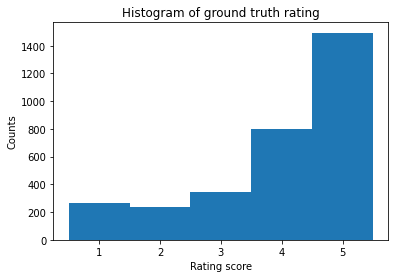

In [ ]:
ground_truth=data_df['ratingScore'].values
bins=np.arange(1,7)-0.5
plt.hist(ground_truth,bins)
plt.xticks(range(1,6))
plt.title('Histogram of ground truth rating')
plt.xlabel('Rating score')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

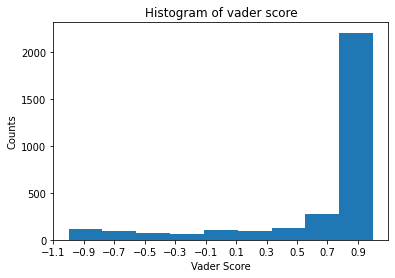

In [ ]:
vader_rating=review_df['vader'].values
bins=np.linspace(-1,1,10)
plt.hist(vader_rating,bins)
ticks=[x*0.1 for x in range(-11,11,2)]
plt.xticks(ticks)
plt.title('Histogram of vader score')
plt.xlabel('Vader Score')
plt.ylabel('Counts')

**The trend in ground truth rating and vader score is pretty similar, but the number of ratings with 4 is far more than vader score around 0.7, I guess this is because a lot of people don't want to give a rating of 5 even though the sentiment of their reviews are quite positive.**

**(ii)**

Text(0, 0.5, 'Counts')

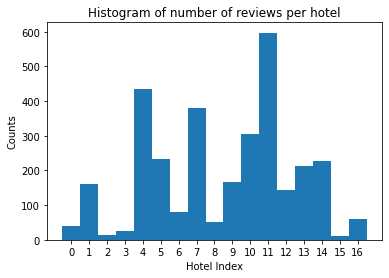

In [ ]:
review_count=data_df['hotelName'].values
bins=np.arange(18)-0.5
plt.hist(review_count,bins)
plt.title('Histogram of number of reviews per hotel')
plt.xticks(range(17),range(17))
plt.xlabel('Hotel Index')
plt.ylabel('Counts')

**There is no trend in this distribution, the highest number of reviews is around 600 and the lowest number of reviews is 10.**

Boxplots

In [ ]:
average_star_rating=data_df.groupby('hotelName')['ratingScore'].mean()
top_5=average_star_rating.sort_values(ascending=False)[:5]
top_5_name=list(top_5.index)

In [ ]:
data_rating=data_df.loc[data_df['hotelName'].isin(top_5_name)]
data_rating=data_rating.loc[:,['hotelName','ratingScore']]
data_vader=review_df.loc[data_df['hotelName'].isin(top_5_name)]
data_vader=data_vader.loc[:,['hotelName','vader']]

Text(0.5, 1.0, 'Boxplot of vader score')

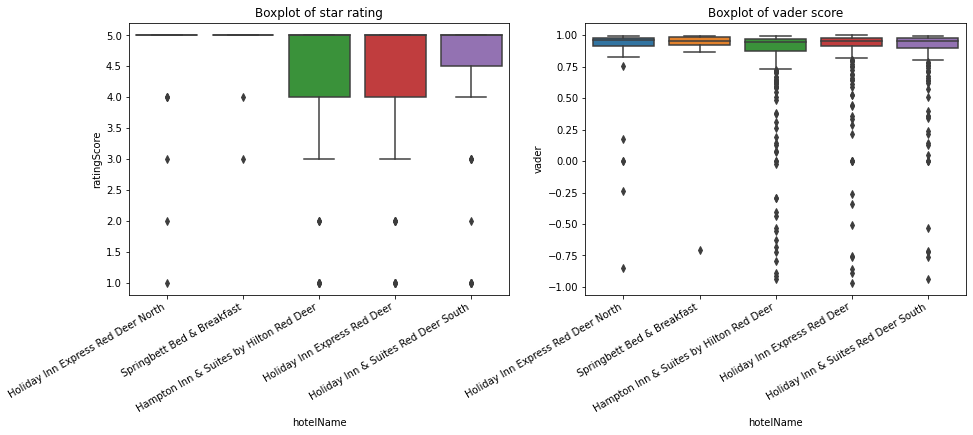

In [ ]:
fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
g=sns.boxplot(x=data_rating['hotelName'],y=data_rating['ratingScore'])
labels=g.get_xticklabels()
g.set_xticklabels(labels,rotation=30,horizontalalignment='right')
g.set_title('Boxplot of star rating')
plt.subplot(1,2,2)
g=sns.boxplot(x=data_vader['hotelName'],y=data_vader['vader'])
labels=g.get_xticklabels()
g.set_xticklabels(labels,rotation=30,horizontalalignment='right')
g.set_title('Boxplot of vader score')

In [ ]:
rating_dict={}
for each in top_5_name:
    mean=data_df[data_df['hotelName']==each]['ratingScore'].values.mean()
    var=np.var(data_df[data_df['hotelName']==each]['ratingScore'].values)
    rating_dict[each]={}
    rating_dict[each]['mean']=mean
    rating_dict[each]['variance']=var


In [ ]:
rating_df=pd.DataFrame(rating_dict)
rating_df

,Springbett Bed & Breakfast,Holiday Inn Express Red Deer North,Holiday Inn & Suites Red Deer South,Hampton Inn & Suites by Hilton Red Deer,Holiday Inn Express Red Deer
mean,4.769231,4.707317,4.629956,4.627586,4.547009
variance,0.331361,0.694825,0.664830,0.527975,0.820440


In [ ]:
vader_dict={}
for each in top_5_name:
    mean=review_df[review_df['hotelName']==each]['vader'].values.mean()
    var=np.var(review_df[review_df['hotelName']==each]['vader'].values)
    vader_dict[each]={}
    vader_dict[each]['mean']=mean
    vader_dict[each]['variance']=var

In [ ]:
vader_df=pd.DataFrame(vader_dict)
vader_df

,Springbett Bed & Breakfast,Holiday Inn Express Red Deer North,Holiday Inn & Suites Red Deer South,Hampton Inn & Suites by Hilton Red Deer,Holiday Inn Express Red Deer
mean,0.825962,0.810549,0.854664,0.849508,0.848004
variance,0.197231,0.154949,0.092374,0.091254,0.112398


Scatterplots and heatmaps

Text(0.5, 1.0, 'Scatter plot of rating score versus vader score')

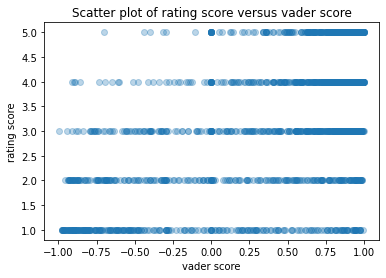

In [ ]:
rating_score=data_df.loc[:,'ratingScore']
vader_score=review_df.loc[:,'vader']
plt.plot(vader_score, rating_score,"o", alpha=0.3)
plt.xlabel('vader score')
plt.ylabel('rating score')
plt.title('Scatter plot of rating score versus vader score')



In [ ]:
k = gaussian_kde(np.vstack([vader_score, rating_score]))
xi, yi = np.mgrid[vader_score.min():vader_score.max():vader_score.size**0.5*1j,rating_score.min():rating_score.max():rating_score.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Text(0.5, 1.0, 'Heatmap of rating score versus vader score')

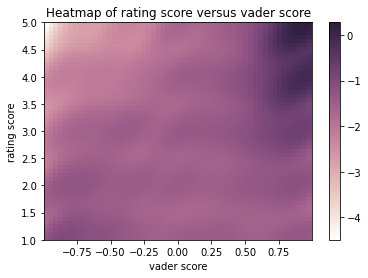

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig,ax=plt.subplots()
b=ax.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax.set_xlim(vader_score.min(), vader_score.max())
ax.set_ylim(rating_score.min(), rating_score.max())
ax.set_xlabel('vader score')
ax.set_ylabel('rating score')
fig.colorbar(b, ax=ax)
ax.set_title('Heatmap of rating score versus vader score')

**I noticed that with a very good vader score, the actual rating score might not be perfect, and with a very low vader score, the actual rating score can also be very high. It means the sentiment in customers' reviews does not directly reflect the rating score they actually gave. There are some people tend to give high rating even the hotel is not what they expected and there are also people tend to give low rating score even though the hotel is generally good in their reviews.**

In [ ]:
length=[len(x) for x in data_df['reviewColumn']]
length=np.array(length)

Text(0.5, 1.0, 'Scatter plot of review length versus rating score')

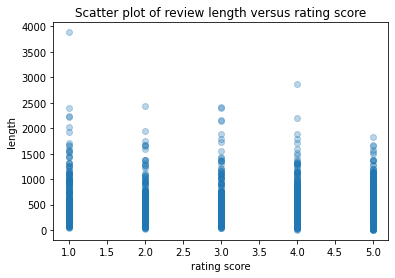

In [ ]:
plt.plot(rating_score, length,"o", alpha=0.3)
plt.xlabel('rating score')
plt.ylabel('length')
plt.title('Scatter plot of review length versus rating score')

Text(0.5, 1.0, 'Scatter plot of review length versus vader score')

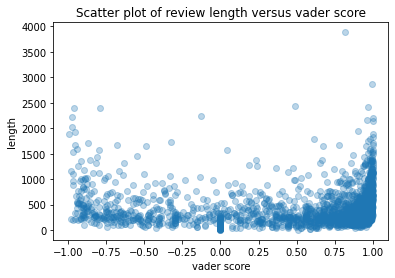

In [ ]:
plt.plot(vader_score, length,"o", alpha=0.3)
plt.xlabel('vader score')
plt.ylabel('length')
plt.title('Scatter plot of review length versus vader score')

Text(0.5, 1.0, 'Heatmap of review length versus rating score')

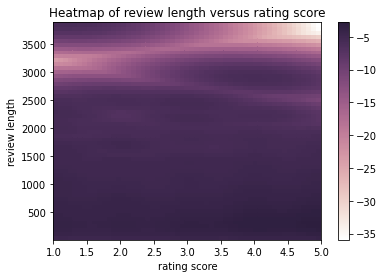

In [ ]:
k = gaussian_kde(np.vstack([rating_score, length]))
xi, yi = np.mgrid[rating_score.min():rating_score.max():rating_score.size**0.5*1j,length.min():length.max():length.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig,ax=plt.subplots()
b=ax.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax.set_xlim(rating_score.min(), rating_score.max())
ax.set_ylim(length.min(), length.max())
ax.set_xlabel('rating score')
ax.set_ylabel('review length')
fig.colorbar(b, ax=ax)
ax.set_title('Heatmap of review length versus rating score')


Text(0.5, 1.0, 'Heatmap of review length versus vader score')

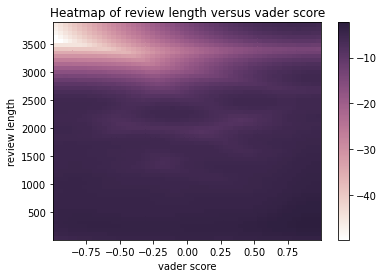

In [ ]:
k = gaussian_kde(np.vstack([vader_score, length]))
xi, yi = np.mgrid[vader_score.min():vader_score.max():vader_score.size**0.5*1j,length.min():length.max():length.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig,ax=plt.subplots()
b=ax.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax.set_xlim(vader_score.min(), vader_score.max())
ax.set_ylim(length.min(), length.max())
ax.set_xlabel('vader score')
ax.set_ylabel('review length')
fig.colorbar(b, ax=ax)
ax.set_title('Heatmap of review length versus vader score')

**The length of review doesn't affect the actual rating, most reveiws have length below 2000, but review with greater length tends to get extreme vader score (-1 or 1). And there is something interesting, the review with greatest length has an actual rating of 1, but it got a pretty good vader score. I think the reason for this is that the review has many positive words but there is something that the customer can't tolerate so this customer gave a rating of 1.**

In [ ]:
num_reviews=data_df.groupby('hotelName')['ratingScore'].count().values
average_rating=data_df.groupby('hotelName')['ratingScore'].mean().values
average_vader=review_df.groupby('hotelName')['vader'].mean().values

Text(0.5, 1.0, 'Scatter plot of number of reviews versus average rating score')

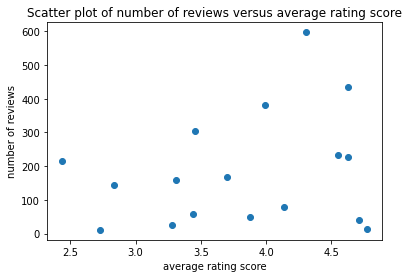

In [ ]:
plt.plot(average_rating, num_reviews,"o")
plt.xlabel('average rating score')
plt.ylabel('number of reviews')
plt.title('Scatter plot of number of reviews versus average rating score')

Text(0.5, 1.0, 'Scatter plot of number of reviews versus average vader score')

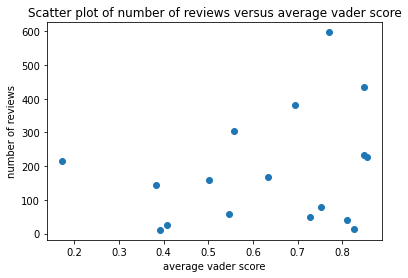

In [ ]:
plt.plot(average_vader, num_reviews,"o")
plt.xlabel('average vader score')
plt.ylabel('number of reviews')
plt.title('Scatter plot of number of reviews versus average vader score')

**There is no specific trend in both cases, maybe it's because the number of hotels I use is small. Hotels with large number of reviews can get higher average rating but hotels with small number of reviews can also get high average rating in my dataset.**

Location-based pattern

In [ ]:
def avg_rating_per_hotel(df):
    tempDf = df
    tempDf.columns = ['hotelName','AverageRatingScore','n_reviews','AverageVader']
    tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
    return tempDf

In [ ]:
temp_df=data_df[['hotelName','ratingScore','reviewColumn']]
geo_df=temp_df.copy()
geo_df['vader']=list(review_df['vader'])
avg_rating_df=avg_rating_per_hotel(geo_df)

In [ ]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']
geo_df=avg_rating_df.join(data_df.groupby('hotelName').agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_df['formed_address'] = geo_df.apply(make_address , axis=1)

In [ ]:
locator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
geo_df['location'] = geo_df['formed_address'].apply(geocode)
geo_df['point'] = geo_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
geo_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_df['point'].tolist(), index=geo_df.index)

In [ ]:
geo_df.at['Holiday Inn Express Red Deer','latitude']=52.245505
geo_df.at['Holiday Inn Express Red Deer','longitude']=-113.812622
geo_df.at['Holiday Inn Express Red Deer','altitude']=0
geo_df.at['Holiday Inn Express Red Deer','point']=(52,245505,-113.812622)

In [ ]:
import html
map1 = folium.Map(
    location=[52.262476,-113.813551], 
    tiles='cartodbpositron',
    zoom_start=12,
)

geo_df.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], color='#d7191c').add_to(map1), axis=1)

for each in range(len(geo_df)):
    locations=[geo_df.iloc[each,:]['latitude']]
    locations.append(geo_df.iloc[each,:]['longitude'])
    avg_rating=geo_df.iloc[each,:]['AverageRatingScore']
    avg_vader=geo_df.iloc[each,:]['AverageVader']
    folium.Marker(locations,popup=html.escape("Average Rating:{}, Average Vader:{}".format(round(avg_rating,1),round(avg_vader,1)))).add_to(map1)

map1

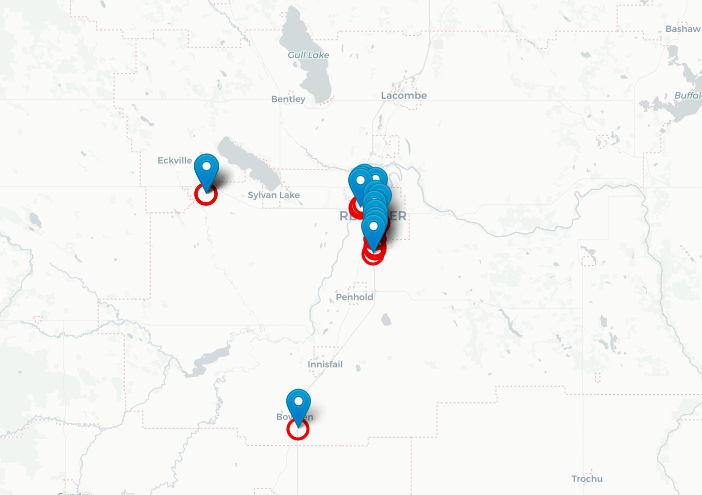

In [ ]:
display(Image.open('map.png'))

**There is no obvious relations between location and rating. I would recommend hotels on Gaetz Avenue since most hotels are on this street and it should be a very convenient location.**

Temporal analysis

In [ ]:
highly_rated=['Radisson Red Deer','Hampton Inn & Suites by Hilton Red Deer']
mediocre_rated=['Super 8 by Wyndham Red Deer','Ramada by Wyndham Red Deer Hotel and Suites']
lowly_rated=['Sandman Hotel Red Deer','Black Knight Inn']
hotels=['Radisson Red Deer','Hampton Inn & Suites by Hilton Red Deer','Super 8 by Wyndham Red Deer','Ramada by Wyndham Red Deer Hotel and Suites','Sandman Hotel Red Deer','Black Knight Inn']

In [ ]:
np.where((data_df['date_stamp']=='2 weeks ago')==True)

(array([ 673, 1366]),)

In [ ]:
temp_df=data_df.drop([673,1366])

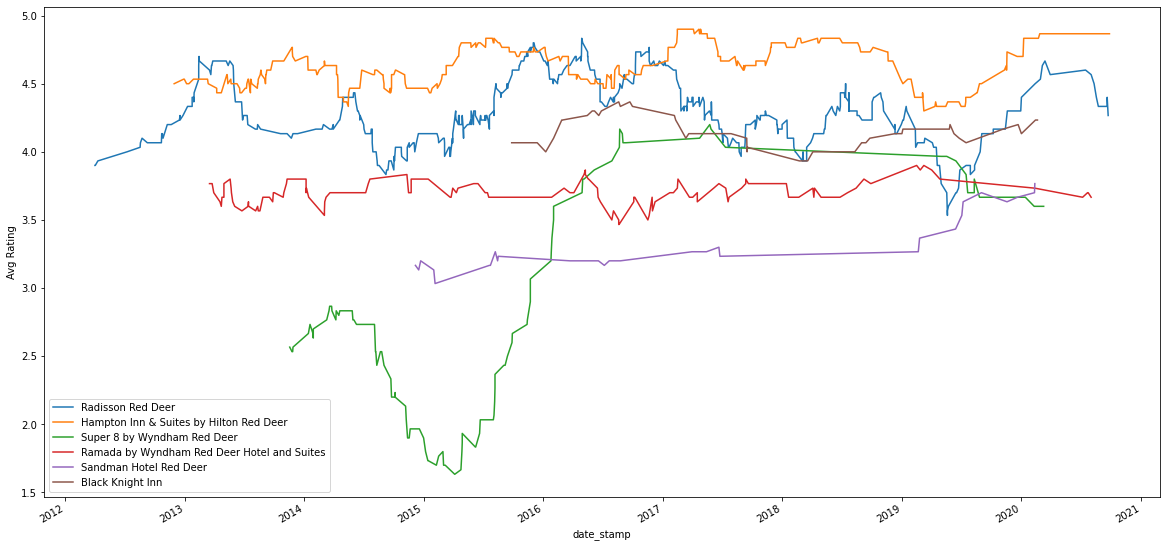

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
for hotel in hotels: 
  _df = temp_df[temp_df['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['ratingScore'].rolling(30).mean().plot(ax=ax,label=hotel)

ax.set_ylabel('Avg Rating')
plt.legend()

**One of the highly rated hotel: Radisson Red Deer, and one of mediocre rated hotel: Super 8 by Wyndham Red Deer Hotel and Suites, fluctuates a lot, other hotels are quite stable.**

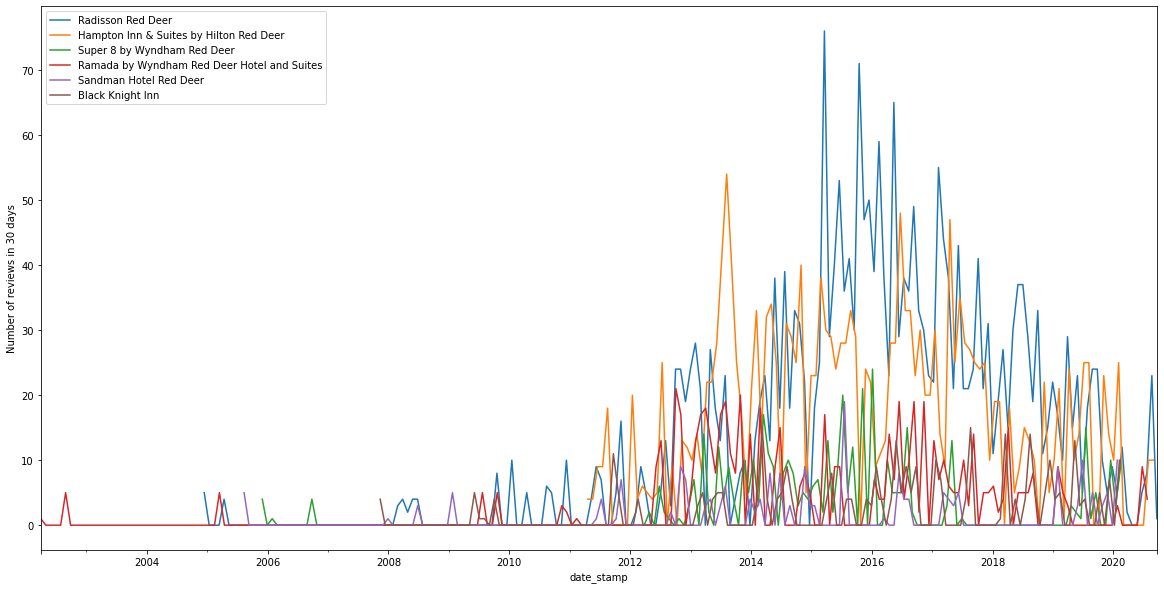

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
for hotel in hotels: 
  _df = temp_df[temp_df['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['ratingScore'].resample('30D').sum().plot(ax=ax,label=hotel)

ax.set_ylabel('Number of reviews in 30 days')
plt.legend()

**It's quite obvious that almost hotels with higher number of ratings have higher number of rating in 30 days from 2015 to 2017, I assume this is because Red Deer is very close to Edmonton and the development of Edmonton brings economy growth to Red Deer as well, there may be more people commute between Red Deer and Edmonton during that period.**